In [16]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = "white"

# Tips and Tricks

1. Objective function can be multivariable, but must be scalar-valued, i.e. 
$f: \reals^n \to \reals$. 
2. Define the multivariable function as:
```
def objective(x: list): 
    x = np.array(x) 
    pass 
```
since the `space` parameter in `fmin` requires a single list input.

3. A tighter bound on the parameters around the true minimum will obviously 
yield better results. 
4. Perform many trials (e.g. $n=10000$) to form a distribution of parameters. 

# Single variable
Minimise $f(x) = x^2$ over the domain $x \in [-10, 10]$. 

In [9]:
def parabola(x):
    """
    A parabola.
    """
    return x ** 2

best = fmin(
    fn=parabola,
    space=hp.uniform('x', -10, 10),
    algo=tpe.suggest,
    max_evals=500
)
print(best)

100%|██████████| 500/500 [00:00<00:00, 712.16trial/s, best loss: 1.2379997510292841e-05] 
{'x': 0.0035185220633517193}


# Multi-variable
Minimise $f(\mathbf{x}) = x^2 + y^2$, where $\mathbf{x} = (x, y) \in \reals^2$. 

In [38]:
def sphere(x: list):
    return sum(np.array(x) ** 2)

best = fmin(
    fn=sphere,
    space=[
        hp.uniform('x', -1, 1),
        hp.uniform('y', -1, 1)
    ],
    algo=tpe.suggest,
    max_evals=1000
)
print(best)

100%|██████████| 1000/1000 [00:03<00:00, 313.40trial/s, best loss: 1.9583566081232086e-05]
{'x': 0.00024240338198594155, 'y': 0.0044186883440262975}


# Retain Information
A call of `fmin` will perform a specified number of trials (`max_evals`). Each 
time a trial is performed, the objective function will be returned. It is 
possible to write the objective function so that it return a dictionary of 
additional information for every trial about which you might be curious. 

The returned dictionary must have the keys `loss` and `status`. Other keys are 
completely flexible. 

In [11]:
def objective(x):
    """
    Another simple parabola. Suppose we would like to know whether or not each 
    trial used a positive or negative hyperparameter x. 
    """
    extra_info = ""
    if x > 0:
        extra_info = "pos"
    elif x < 0:
        extra_info = "neg"
    else:
        extra_info = "zero"
    
    return {
        'loss': x ** 2,         # the scalar output value of the function
        'status': STATUS_OK,    # unsure
        # results you are curious about
        'other_stuff': {'type': str, 'value': extra_info}
    }

# make a new trials object
trials = Trials()
best = fmin(
    objective,
    space=hp.uniform('x', -10, 10),
    algo=tpe.suggest,
    max_evals=500,
    trials=trials       # every trial will be stored in the trials object
)
print(best)

100%|██████████| 500/500 [00:00<00:00, 679.95trial/s, best loss: 7.433509478477105e-07] 
{'x': -0.0008621780256117123}


Now we are able to access information about the trial. 

In [12]:
# trials.trials is a list of dictionaries representing everything about the search
# everything about the first trial
print(trials.trials[0])
# everything about the last (500th) trial
print(trials.trials[-1])

{'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': 2.461252560832373, 'status': 'ok', 'other_stuff': {'type': <class 'str'>, 'value': 'pos'}}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'x': [0]}, 'vals': {'x': [1.568837965129724]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2022, 7, 13, 6, 33, 16, 191000), 'refresh_time': datetime.datetime(2022, 7, 13, 6, 33, 16, 191000)}
{'state': 2, 'tid': 499, 'spec': None, 'result': {'loss': 0.3545849064288783, 'status': 'ok', 'other_stuff': {'type': <class 'str'>, 'value': 'neg'}}, 'misc': {'tid': 499, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'x': [499]}, 'vals': {'x': [-0.5954703237180492]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2022, 7, 13, 6, 33, 16, 925000), 'refresh_time': datetime.datetime(2022, 7, 13, 6, 33, 16, 925000)}


In [13]:
# trials.results is a list of dictionaries returned by the objective during search
print(trials.results[0])
print(trials.results[-1])

{'loss': 2.461252560832373, 'status': 'ok', 'other_stuff': {'type': <class 'str'>, 'value': 'pos'}}
{'loss': 0.3545849064288783, 'status': 'ok', 'other_stuff': {'type': <class 'str'>, 'value': 'neg'}}


2.461252560832373
0.3545849064288783


Text(0, 0.5, 'Loss')

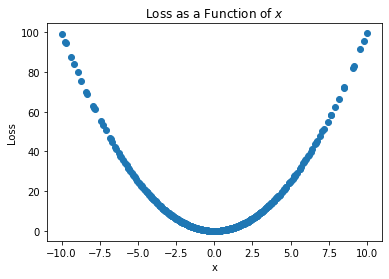

In [14]:
# trials.losses() is a list of loss values
x_s = [trials.trials[i]['misc']['vals']['x'] for i in range(len(trials.losses()))]
losses = trials.losses()
print(losses[0])
print(losses[-1])
plt.scatter(x_s, losses)
plt.title("Loss as a Function of $x$")
plt.xlabel("x")
plt.ylabel("Loss")

# Distribution of Hyperparameters
Only getting a single best parameter is often not very useful, due to the random 
nature of Bayesian optimisation. It is better practice to perform multiple calls 
of `fmin` and forming a distribution of these results. 

In [35]:
n = 300
optimised_params = []
for i in range(n):
    best = fmin(
        fn=sphere,
        space=[hp.uniform('x', -2, 2), hp.uniform('y', -2, 2)],
        algo=tpe.suggest,
        max_evals=100,
        show_progressbar=False
    )

    optimised_params.append(best)
    print("Done: {} / {}".format(i + 1, n))


Done: 1 / 300
Done: 2 / 300
Done: 3 / 300
Done: 4 / 300
Done: 5 / 300
Done: 6 / 300
Done: 7 / 300
Done: 8 / 300
Done: 9 / 300
Done: 10 / 300
Done: 11 / 300
Done: 12 / 300
Done: 13 / 300
Done: 14 / 300
Done: 15 / 300
Done: 16 / 300
Done: 17 / 300
Done: 18 / 300
Done: 19 / 300
Done: 20 / 300
Done: 21 / 300
Done: 22 / 300
Done: 23 / 300
Done: 24 / 300
Done: 25 / 300
Done: 26 / 300
Done: 27 / 300
Done: 28 / 300
Done: 29 / 300
Done: 30 / 300
Done: 31 / 300
Done: 32 / 300
Done: 33 / 300
Done: 34 / 300
Done: 35 / 300
Done: 36 / 300
Done: 37 / 300
Done: 38 / 300
Done: 39 / 300
Done: 40 / 300
Done: 41 / 300
Done: 42 / 300
Done: 43 / 300
Done: 44 / 300
Done: 45 / 300
Done: 46 / 300
Done: 47 / 300
Done: 48 / 300
Done: 49 / 300
Done: 50 / 300
Done: 51 / 300
Done: 52 / 300
Done: 53 / 300
Done: 54 / 300
Done: 55 / 300
Done: 56 / 300
Done: 57 / 300
Done: 58 / 300
Done: 59 / 300
Done: 60 / 300
Done: 61 / 300
Done: 62 / 300
Done: 63 / 300
Done: 64 / 300
Done: 65 / 300
Done: 66 / 300
Done: 67 / 300
Done

In [36]:
df = pd.DataFrame(optimised_params)
df.head()

,x,y
0,0.026062,-0.159885
1,0.010243,0.008067
2,-0.083737,-0.038757
3,-0.061591,0.113500
4,-0.240181,-0.048707


x: mean: 5.2923964117657835e-05, stdev: 0.08203890856569714
y: 0.0020717890738042475, stdev: 0.08463410293688535


array([[<AxesSubplot:title={'center':'y'}>]], dtype=object)

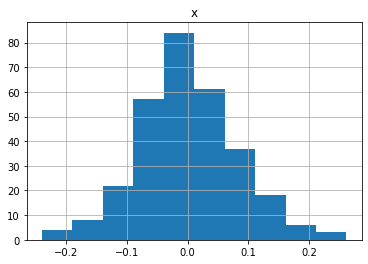

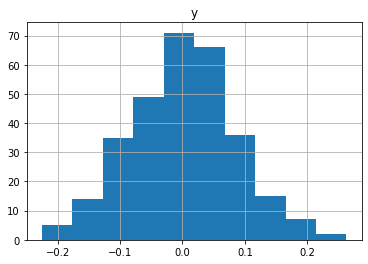

In [37]:
print("x: mean: {}, stdev: {}".format(df['x'].mean(), df['x'].std()))
print("y: {}, stdev: {}".format(df['y'].mean(), df['y'].std()))
df.hist('x')
df.hist('y')